# This notebook demonstrates how to compare the model assigned attributions to the ground truth attributions assigned via the Contribution deterministic binding rule

You can incorporate the `avg_rank_above_threshold` and `get_high_rank_sum_stat` functions to analyse attributions generated using the `compute_attributions` script with the Contribution generative process

In [1]:
%config Completer.use_jedi = False

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import math

For the contribution generative process, our primary interest is in assessing whether a virtual screening model can assign a high rank to the most important atoms. To quantify this, for a given threshold we compute the average model-assigned rank of all atoms with a ground-truth ligand score above the threshold.

In [2]:
def avg_rank_above_threshold(threshold, df, sort_by_binding = False, random_ranking = False):
    
    if sort_by_binding:
        df = df.sort_values('binding', ascending = False).reset_index(drop=True)
    
    if random_ranking:
        df['random'] = np.random.uniform(size=df.shape[0])
        df = df.sort_values('random', ascending = False).reset_index(drop=True)
    
    above_df = df.loc[df['binding'] > threshold]
    
    indices_above_threshold = list(above_df.index)
    indices_above_threshold = [x + 1 for x in indices_above_threshold]
    
    if len(indices_above_threshold) == 0:
        return -1
    else:
        return np.mean(indices_above_threshold)
    
    
def get_high_rank_sum_stat(df_list, thresholds, sort_by_binding = False, random_ranking = False):
    
    all_thresholds = []
    
    for t in thresholds:
        
        df_ranks = []
        
        for df in df_list:
            single_example = avg_rank_above_threshold(t, df, sort_by_binding, random_ranking)
            if single_example != -1:
                df_ranks.append(single_example)
            
        all_thresholds.append(np.mean(df_ranks))
    
    return all_thresholds




Computing the average rank of above-threshold atoms makes more sense when you have a larger number of examples to work with, so we'll load in a set of 500 attribution DataFrames

In [3]:
dfs_fnames = glob.glob('../data/contribution_attributions/df*.csv')
dfs = [pd.read_csv(x, sep = ' ') for x in dfs_fnames]
print(len(dfs_fnames))

500


In [4]:
dfs[0] 

,atom_idx,x,y,z,attribution,binding
0,0,-1.4403,-2.5451,-1.3388,0.413901,2.628034
1,1,-1.1892,-1.5401,-0.4217,0.254604,0.000000
2,3,0.4870,-0.1775,0.3962,0.020507,0.000000
3,12,-1.8056,0.6202,0.4806,0.020507,0.000000
4,4,1.9122,0.2332,0.1741,0.013870,0.000000
5,14,-2.0947,-0.3379,-0.6660,0.007625,0.000000
6,10,-0.3802,1.0741,0.3143,0.006870,0.000000
7,5,2.7575,-0.8180,-0.1302,0.000000,0.266469
8,6,4.3762,-0.2904,0.1058,0.000000,0.000000
9,7,4.5882,1.0573,-0.5997,0.000000,0.487414


Above we see an example attribution dataframe. We have the index and 3D position of each atom; `attribution` describes the model attribution, whilst `binding` denotes the ground truth atom contribution. Note that we do not expect these values to be similar in terms of absolute value, as the model attributions are constrained to be in between -1 and 1, whereas the ground truth contributions are always positive. Rather, we are interested in the atomic rankings given by the two measures.

In [5]:
avg_rank_model = get_high_rank_sum_stat(dfs, np.arange(0.5, 3, 0.05))


Use random ranking and perfect ranking as baselines

In [6]:
avg_rank_best = get_high_rank_sum_stat(dfs, np.arange(0.5, 3, 0.05), sort_by_binding=True)
avg_rank_random = get_high_rank_sum_stat(dfs, np.arange(0.5, 3, 0.05), random_ranking=True)


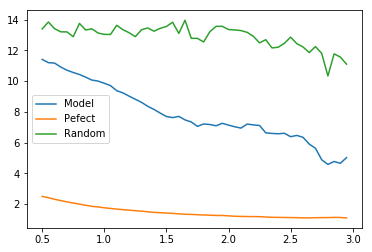

In [7]:
plt.plot(np.arange(0.5, 3, 0.05), avg_rank_model, label = 'Model')
plt.plot(np.arange(0.5, 3, 0.05), avg_rank_best, label = 'Pefect')
plt.plot(np.arange(0.5, 3, 0.05), avg_rank_random, label = 'Random')

plt.legend()
plt.show()

We can see that the average rank assigned to high scoring atoms by the model is considerably worse than the perfect ranking as the average ranks are much higher. The model also clearly outperforms the random baseline.